# Requirements and installs

In [1]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [2]:
import typing as t
import numpy as np
import pandas as pd
from dataclasses import dataclass
from zoneinfo import ZoneInfo
import unicodedata, re
import matplotlib.pyplot as plt
import seaborn as sns

# Utils básicos
def _pip_install(pkg):
    try:
        __import__(pkg.split("==")[0].replace("-", "_"))
    except ImportError:
        import subprocess, sys
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

for pkg in ["holidays"]:
    _pip_install(pkg)

import holidays
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import average_precision_score, roc_auc_score, brier_score_loss
from sklearn.calibration import IsotonicRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.utils import Bunch
from sklearn.utils.class_weight import compute_sample_weight
from fairlearn.metrics import MetricFrame
from sklearn.calibration import calibration_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report
from sklearn.preprocessing import RobustScaler


from scipy.stats import ks_2samp
from scipy import stats

import optuna
from optuna.pruners import MedianPruner

import warnings
warnings.filterwarnings('ignore')

# Configuración visual
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


RNG_SEED = 42
np.random.seed(RNG_SEED)

# Config

In [3]:
@dataclass
class Config:
    project_id: str = "spin-aip-singularity-comp-sb"
    table_fqn: str = "spin-aip-singularity-comp-sb.model_activation.dataste_model_activation_timewindow_30D_V-1-5-0"
    label_col: str = "label_activated_30d"
    signup_ts_col: str = "signup_ts"
    signup_date_col: str = "signup_date"
    tz_local: str = "America/Mexico_City"
    embargo_days: int = 3      
    holdout_days: int = 14 
    n_splits: int = 5
    train_sample_frac: float = 1.0
    random_state: int = RNG_SEED
    lift_fracs: t.Tuple[float, ...] = (0.01, 0.02, 0.05, 0.10)

CFG = Config()

# Leakage / IDs a ignorar en features
LEAKY_ALWAYS = {
    # labels y derivados
    "y_w0","y_w1","y_w7","y_w30","y_cum30","label_activated_30d","label_5tx_30d",
    # info post-activación / post-window
    "activation_date_ever","activation_date_30d","days_to_first_activation",
    "tx_30d_count","tx_30d_amount","tx_30d_from_activation", "first_tx_type","first_tx_amount","latest_tx_date",
    # confirmaciones si no son estrictamente previas al cutoff de cada horizonte
#    "phn_confir","email_confir",
    "phn_confir_d7","email_confir_d7","both_confir_d7",'Card_linked_date',"activation_*","*_30d_*","*latest_tx*",
    #ID
    "user_id", "userid","channelUserIdentifier", "premia_accountid", "accountid", "member_id", "spin_user_id", "id"
}

LEAK_BAN = {
    "y_w0","y_w1","y_w7","y_w30","y_cum30","label_activated_30d","label_5tx_30d",
    "activation_date_ever","activation_date_30d","days_to_first_activation",
    "latest_tx_date","tx_30d_count","tx_30d_amount","tx_30d_from_activation",
    "first_tx_type","first_tx_amount","activation_channel"
}

# Regex anti-leak (además del set LEAKY_ALWAYS existente)
LEAK_PATTERNS = [
    r"(^|_)activation(_|$)", r"(^|_)first_tx(_|$)", r"(^|_)latest_tx(_|$)",
    r"(^|_)tx_30d(_|$)", r"(^|_)days_to_first(_|$)", r"(^|_)from_activation(_|$)"
]
def assert_no_regex_leak(df_like: pd.DataFrame):
    bad = []
    for c in df_like.columns:
        for pat in LEAK_PATTERNS:
            if re.search(pat, c, flags=re.IGNORECASE):
                bad.append(c); break
    assert len(bad) == 0, f"LEAKAGE by regex: quita columnas {sorted(set(bad))}"
def assert_no_labelish_cols(df_like):
    inter = [c for c in df_like.columns if c in LEAK_BAN]
    assert len(inter) == 0, f"LEAKAGE: quita columnas {inter}"


EXTRA_DROP_TS = {"phone_conf_ts", "email_conf_ts"}

# Normalización de estados (stateName -> siglas)
def _norm(s: str) -> str:
    s = unicodedata.normalize("NFKD", s).encode("ascii", "ignore").decode("ascii")
    s = re.sub(r"[^A-Z ]", "", s.upper())
    return re.sub(r"\s+", " ", s).strip()

STATE_TO_ABBR = {
    "AGUASCALIENTES":"AG","BAJA CALIFORNIA":"BC","BAJA CALIFORNIA SUR":"BS","CAMPECHE":"CM",
    "CHIAPAS":"CS","CHIHUAHUA":"CH","CIUDAD DE MEXICO":"DF","COAHUILA":"CO","COLIMA":"CL",
    "DURANGO":"DG","GUANAJUATO":"GT","GUERRERO":"GR","HIDALGO":"HG","JALISCO":"JA","MEXICO":"EM",
    "MICHOACAN":"MI","MORELOS":"MO","NAYARIT":"NA","NUEVO LEON":"NL","OAXACA":"OA","PUEBLA":"PU",
    "QUERETARO":"QT","QUINTANA ROO":"QR","SAN LUIS POTOSI":"SL","SINALOA":"SI","SONORA":"SO",
    "TABASCO":"TB","TAMAULIPAS":"TM","TLAXCALA":"TL","VERACRUZ":"VE","YUCATAN":"YU","ZACATECAS":"ZA"
}
STATE_SYNONYMS = {"CDMX":"CIUDAD DE MEXICO","ESTADO DE MEXICO":"MEXICO","EDOMEX":"MEXICO"}

# birthState canon + buckets regionales
CANON = {
    "SR":"SO","SO":"SO","VZ":"VE","VE":"VE","YN":"YU","YU":"YU","JC":"JA","JA":"JA","MC":"MI","MI":"MI",
    "TS":"TM","TM":"TM","TC":"TB","TB":"TB","CC":"CL","CL":"CL","DF":"DF","EM":"EM","NL":"NL","BC":"BC",
    "BS":"BS","SI":"SI","NA":"NA","DG":"DG","ZA":"ZA","AG":"AG","SL":"SL","HG":"HG","MO":"MO","TL":"TL",
    "PU":"PU","QT":"QT","GT":"GT","OA":"OA","CM":"CM","CS":"CS","CO":"CO","GR":"GR","QR":"QR","CH":"CH",
    "MS":"MI","MN":"MI","SP":"SL","NE":"NL","OC":"OA","PL":"PU","NT":"NA","ZS":"ZA","AS":"AG","UN":"OT", None:"OT"
}
REGION_BUCKET = {
    "BC":1,"SO":1,"CH":1,"CO":1,"NL":1,"TM":1,                # Norte
    "BS":2,"SI":2,"NA":2,"DG":2,"ZA":2,                       # Norte-Occidente
    "JA":3,"AG":3,"CL":3,"MI":3,"SL":3,                       # Centro-Norte
    "DF":4,"EM":4,"HG":4,"MO":4,"TL":4,"PU":4,"QT":4,"GT":4,  # Centro-País
    "CS":5,"TB":5,"CM":5,"YU":5,"QR":5,"OA":5,"GR":5,"VE":5,  # Sur-Sureste
    "OT":0
}

# Mapeos categóricos
GENDER_MAP = {"female":1, "male":0}
USER_TYPE_MAP = {"HYBRID":0, "DIGITAL":1, "ANALOG":2}
CHANNEL_DETAIL_MAP = {"ORGANIC":0,"COLLABORATOR":1,"POS":2,"SPIN_PREMIA":3,"DIGITAL_ORGANIC":4,"DIGITAL":5}

#CASH_IN_TX = {"CASH_IN_AT_OXXO","CASH_IN_AT_OXXO_QR"}

#SPEI_TX = {"SPEI_CASH_IN"}

#P2P_TX = {"P2P_TRANSFER_TARGET","P2P_TRANSFER_TARGET_CLABE","P2P_TRANSFER_TARGET","P2P_TRANSFER_TARGET_CARD"}

CASH_IN_TX = {
    "CASH_IN_AT_OXXO","CASH_IN_AT_OXXO_QR","CASH_OUT_WITH_CARD_AT_OXXO", "CASH_OUT_AT_OXXO","CASH_OUT_AT_MERCHANT","CARD_PURCHASE","CARD_ATM_WITHDRAWAL"
}
SPEI_TX = {"SPEI_CASH_IN","TRANSFER_TO_CARD","TRANSFER_TO_CLABE" "P2P_TRANSFER_TARGET","P2P_TRANSFER_TARGET_CLABE","P2P_TRANSFER_TARGET","P2P_TRANSFER_TARGET_CARD"}
   
P2P_TX ={"P2P_TRANSFER_TARGET_CLABE","P2P_TRANSFER_TARGET","P2P_TRANSFER_TARGET_CARD","P2P_TRANSFER_SOURCE_CARD","P2P_TRANSFER_SOURCE_CLABE",
    "P2P_TRANSFER_SOURCE","IN_APP_PURCHASE_TAE","IN_APP_PURCHASE_BILLPAYMENT","QR_MERCHANT_PAYMENT",
    "GIFT_CARD_PURCHASE","INTERNATIONAL_REMITTANCE_CASH_IN"}
    
TX_TYPE_MAP = {
    **{k: 0 for k in CASH_IN_TX},  # 0 = Cash_In
    **{k: 1 for k in SPEI_TX},     # 1 = SPEI
    **{k: 2 for k in P2P_TX}       # 2 = P2P
}
TX_TYPE_NAMES = {
    0: "Cash_In",
    1: "SPEI",
    2: "P2P"
}
TX_TRINARY_NAME = {0:"FISICAS", 1:"DIGITALES", 2:"P2P"}


# FeatureBuilder

In [4]:
class FeatureBuilder:
    def __init__(self, cfg: Config):
        self.cfg = cfg
        self.ohe_states_: t.List[str] = []
        # NUEVO: Pipeline de normalización
        self.scaler_: RobustScaler | None = None
        self.numeric_cols_: t.List[str] = []
        self._fitted_scaler: bool = False

    @staticmethod
    def _state_to_abbr(s: t.Any) -> str:
        if pd.isna(s): return "OT"
        s = str(s)
        if s.upper() in REGION_BUCKET: return s.upper()
        s2 = _norm(s)
        s2 = STATE_SYNONYMS.get(s2, s2)
        return STATE_TO_ABBR.get(s2, "OT")

    @staticmethod
    def _canon_birthstate(s: t.Any) -> str:
        if pd.isna(s): return "OT"
        s = str(s).upper()
        return CANON.get(s, s if s in REGION_BUCKET else "OT")

    def _mk_time_feats(self, df: pd.DataFrame) -> pd.DataFrame:
        ts = pd.to_datetime(df[self.cfg.signup_ts_col], utc=True).dt.tz_convert(ZoneInfo(self.cfg.tz_local))
        df = df.copy()
        df["signup_dow"] = ts.dt.weekday.astype("int16")
        df["signup_week"] = ts.dt.isocalendar().week.astype("int16")
        df["signup_month"] = ts.dt.month.astype("int16")
        hr = ts.dt.hour
        df["signup_daypart"] = np.select([(hr>=5)&(hr<=11),(hr>=12)&(hr<=17)],[0,1],default=2).astype("int8")
        years = list({d.year for d in pd.to_datetime(df[self.cfg.signup_date_col]).dt.date})
        mx_hol = holidays.MX(years=years)
        dates = pd.to_datetime(df[self.cfg.signup_date_col]).dt.date
        df["is_holiday_mx"] = dates.map(lambda d: 1 if d in mx_hol else 0).astype("int8")
        day = ts.dt.day
        eom = (ts + pd.offsets.MonthEnd(0)).dt.day
        df["near_payday_any"] = ((np.abs(day-1)<=3)|(np.abs(day-15)<=3)|(np.abs(day-eom)<=3)).astype("int8")
        df["near_payday_1st"] = (np.abs(day-1)<=3).astype("int8")
        df["near_payday_15"]  = (np.abs(day-15)<=3).astype("int8")
        df["near_payday_eom"] = (np.abs(day-eom)<=3).astype("int8")
        return df

    def fit(self, df: pd.DataFrame):
        st = df["stateName"].map(self._state_to_abbr)
        self.ohe_states_ = sorted(st.dropna().unique().tolist())
        if "OT" not in self.ohe_states_: self.ohe_states_.append("OT")
        return self

    def transform(self, df: pd.DataFrame) -> Bunch:
        df = df.copy()
        s_ts = pd.to_datetime(df[CFG.signup_ts_col], utc=True)

        # Categóricas core
        df["gender_bin"] = df["gender"].map(GENDER_MAP).astype("float32")
        df["user_type_tri"] = df["user_type"].map(USER_TYPE_MAP).astype("float32")
        df["channel_detail_code"] = df["channelDetail"].map(CHANNEL_DETAIL_MAP).astype("float32")

        # birth bucket + edad
        bcanon = df["birthState"].map(self._canon_birthstate)
        df["birth_bucket"] = bcanon.map(REGION_BUCKET).astype("float32")
        bdate = pd.to_datetime(df["birth_date"], errors="coerce", utc=True)
        df["age_years"] = ((s_ts - bdate).dt.days/365.25).astype("float32")

        # Time features
        df = self._mk_time_feats(df)

        # state OHE
        st = df["stateName"].map(self._state_to_abbr)
        for ab in self.ohe_states_:
            df[f"state_{ab}"] = (st==ab).astype("int8")

        # Confirmaciones / flags: Int nulos a 0
        if "phone_conf_ts" in df.columns:
            phn_ts = pd.to_datetime(df["phone_conf_ts"], errors="coerce", utc=True)
            df["phn_confir"] = (phn_ts < s_ts).fillna(False).astype("int8")
        else:
            df["phn_confir"] = 0

        if "email_conf_ts" in df.columns:
            email_ts = pd.to_datetime(df["email_conf_ts"], errors="coerce", utc=True)
            df["email_confir"] = (email_ts < s_ts).fillna(False).astype("int8")
        else:
            df["email_confir"] = 0

        # Card_linked_date -> deltas sin fuga
        if "Card_linked_date" in df.columns:
            card_dt = pd.to_datetime(df["Card_linked_date"], errors="coerce", utc=True)
            # Cambiar <= por < (estrictamente antes)
            before = card_dt < s_ts  
            lag_days = (s_ts - card_dt).dt.days.astype("float32")
            df["card_linked_before_signup"] = before.fillna(False).astype("int8")
            # Solo crear lag_days si ocurrió ANTES (no <=)
            df["card_linked_lag_days"] = np.where(before, lag_days, np.nan).astype("float32")
            df = df.drop(columns=["Card_linked_date"])

        LEAKY_FEATURES = {
            'lifespan_days',        #  LEAKAGE CONFIRMADO (corr=0.535)
            'days_since_last',      #  Sospechoso (corr=0.329)
        }

            
        # Armar X
        drop_cols = set(LEAKY_ALWAYS) | {
            "stateName","gender","user_type","channelDetail","birthState","birth_date",
            CFG.signup_date_col, CFG.signup_ts_col
        } | set(EXTRA_DROP_TS) | LEAKY_FEATURES  # ← MODIFICAR ESTA LÍNEA

        drop_cols = [c for c in drop_cols if c in df.columns]
        X = df.drop(columns=drop_cols, errors="ignore")

        # Limpiar tipos
        # 1) Si queda algún dtype extension de BigQuery -> fuera
        bad_ext = [c for c in X.columns if "db_dtypes" in str(X[c].dtype).lower() or "dbdate" in str(X[c].dtype).lower()]
        X = X.drop(columns=bad_ext, errors="ignore")

        # 2) Casts seguros
        for c in X.columns:
            if pd.api.types.is_integer_dtype(X[c]) or str(X[c].dtype).startswith("Int"):
                X[c] = pd.to_numeric(X[c], errors="coerce").fillna(0).astype("float32")
            elif pd.api.types.is_float_dtype(X[c]):
                X[c] = X[c].astype("float32")
            elif pd.api.types.is_bool_dtype(X[c]):
                X[c] = X[c].astype("int8")
            elif pd.api.types.is_datetime64_any_dtype(X[c]):
                X = X.drop(columns=[c])

        # 3) Objetos -> fuera
        obj_cols = X.select_dtypes(include=["object"]).columns.tolist()
        if obj_cols:
            X = X.drop(columns=obj_cols)

        # NUEVO: Normalización con RobustScaler
        if not self._fitted_scaler:
            # Primera vez: identificar columnas numéricas y fit scaler
            numeric_cols = [c for c in X.columns
                            if not c.startswith('state_')  # Excluir one-hot de estados
                            and X[c].dtype == 'float32'     # Solo float32
                            and X[c].nunique() > 10]        # Excluir binarias
            
            self.numeric_cols_ = numeric_cols
            
            if len(numeric_cols) > 0:
                self.scaler_ = RobustScaler()
                self.scaler_.fit(X[numeric_cols])
                self._fitted_scaler = True
                print(f'✓ RobustScaler fitted con {len(numeric_cols)} features numéricas')
            else:
                print('⚠️  No se encontraron features numéricas para normalizar')
                self._fitted_scaler = True
        
        # Aplicar normalización si existe
        if self.scaler_ is not None and len(self.numeric_cols_) > 0:
            existing_cols = [c for c in self.numeric_cols_ if c in X.columns]
            if len(existing_cols) > 0:
                X[existing_cols] = self.scaler_.transform(X[existing_cols])

        # y binaria
        y = pd.to_numeric(df[CFG.label_col], errors="coerce").fillna(0).astype(int).values
        
        assert_no_regex_leak(X)
        LEAK_BAN = LEAKY_ALWAYS | {"first_tx_type", "first_tx_amount"}
        assert_no_labelish_cols(X)
        
        meta = pd.DataFrame({
            "user_id": df.get("user_id", pd.Series(index=df.index, dtype="object")),
            "signup_date": pd.to_datetime(df[CFG.signup_date_col], errors="coerce"),
            "gender": df["gender"].astype(str),
            "channelDetail": df["channelDetail"].astype(str),
            "state_abbr": st.astype(str)
        })
        return Bunch(X=X, y=y, meta=meta)

# Modelo W30

In [5]:
def lift_at_k(y_true, y_score, frac: float) -> float:
    n = len(y_true); k = max(1, int(n*frac))
    idx = np.argpartition(-y_score, k-1)[:k]
    top_pos = y_true[idx].sum()
    base_rate = y_true.mean()
    expected_pos = k*base_rate
    return float(top_pos/expected_pos) if expected_pos>0 else np.nan

class Activation30Model:
    def __init__(self, cfg: Config):
        self.cfg = cfg
        self.model_folds_: t.List[HistGradientBoostingClassifier] = []
        self.iso_folds_: t.List[IsotonicRegression] = []
        self.metrics_ = {}
        self.oof_pred_ = None
        self.feature_names_: t.List[str] = []

    def _make_model(self):
        return HistGradientBoostingClassifier(
            learning_rate=0.05, max_leaf_nodes=31, min_samples_leaf=50,
            l2_regularization=1.0, max_bins=255, random_state=self.cfg.random_state
        )
    def _apply_embargo(self, train_idx: np.ndarray, val_idx: np.ndarray, 
                       time_order: np.ndarray) -> t.Tuple[np.ndarray, np.ndarray]:
        """Purga registros del train/val que violen el embargo temporal"""
        if self.cfg.embargo_days == 0:
            return train_idx, val_idx

        # Convertir a pandas Timestamp para operaciones seguras
        train_dates = pd.to_datetime(time_order[train_idx])
        val_dates = pd.to_datetime(time_order[val_idx])

        # Última fecha de train
        last_train_date = train_dates.max()

        # Calcular embargo cutoff
        embargo_cutoff = last_train_date + pd.Timedelta(days=self.cfg.embargo_days)

        # Filtrar validación
        val_valid_mask = val_dates >= embargo_cutoff
        val_filtered = val_idx[val_valid_mask]

        # VALIDACIÓN CRÍTICA: Asegurar mínimo de muestras
        min_samples = 100  # mínimo razonable para HistGradientBoosting
        if len(val_filtered) < min_samples:
            print(f" WARNING: Embargo dejó {len(val_filtered)} muestras (< {min_samples}). "
                  f"Usando fold completo sin embargo.")
            return train_idx, val_idx

        removed = len(val_idx) - len(val_filtered)
        print(f"✓ Embargo aplicado: {removed} muestras removidas de validación "
              f"({removed/len(val_idx)*100:.1f}%)")

        return train_idx, val_filtered

    def fit_cv(self, X: pd.DataFrame, y: np.ndarray, time_order: np.ndarray):
        # ordenar temporal
        order = np.argsort(time_order)
        X = X.iloc[order].reset_index(drop=True)
        y = y[order]
        time_order_sorted = pd.to_datetime(time_order[order])

        tss = TimeSeriesSplit(n_splits=self.cfg.n_splits)
        oof = np.zeros(len(X), dtype=float)
        self.model_folds_.clear()
        self.iso_folds_.clear()
        self.feature_names_ = X.columns.tolist()

        for f, (tr, va) in enumerate(tss.split(X)):
            # embargo con fechas ya ordenadas
            tr, va = self._apply_embargo(tr, va, time_order_sorted)

            Xtr, Xva = X.iloc[tr], X.iloc[va]
            ytr, yva = y[tr], y[va]

            sw = compute_sample_weight(class_weight="balanced", y=ytr).astype("float32")

            m = self._make_model()
            m.fit(Xtr, ytr, sample_weight=sw)

            p_raw = m.predict_proba(Xva)[:, 1]
            iso = IsotonicRegression(out_of_bounds="clip").fit(p_raw, yva)
            p_cal = iso.transform(p_raw)
            oof[va] = p_cal

            self.model_folds_.append(m)
            self.iso_folds_.append(iso)
            print(f"[Fold {f+1}] AP={average_precision_score(yva,p_cal):.4f} | "
                  f"AUC={roc_auc_score(yva,p_cal):.4f} | "
                  f"Brier={brier_score_loss(yva,p_cal):.4f}")

        self.oof_pred_ = oof
        self.metrics_ = {
            "OOF_AP": average_precision_score(y, oof),
            "OOF_AUC": roc_auc_score(y, oof),
            "OOF_Brier": brier_score_loss(y, oof),
            **{f"OOF_Lift@{int(fr*100)}%": lift_at_k(y, oof, fr) for fr in self.cfg.lift_fracs}
        }
        return self


    def predict_proba(self, X: pd.DataFrame) -> np.ndarray:
        preds = np.zeros(len(X), dtype=float)
        for m, iso in zip(self.model_folds_, self.iso_folds_):
            preds += iso.transform(m.predict_proba(X)[:,1])
        return preds / max(1, len(self.model_folds_))

# Model type of transaction

In [6]:
class TxTypeModel:
    def __init__(self, cfg: Config):
        self.cfg = cfg
        self.model_: HistGradientBoostingClassifier | None = None
        self.classes_: np.ndarray | None = None

    def _make_model(self):
        return HistGradientBoostingClassifier(
            learning_rate=0.05, max_leaf_nodes=31, min_samples_leaf=50,
            l2_regularization=1.0, max_bins=255, random_state=self.cfg.random_state
        )

    def fit(self, X: pd.DataFrame, y_tx: np.ndarray):
        # Pesos por clase inversos a la frecuencia
        classes, counts = np.unique(y_tx, return_counts=True)
        inv_freq = {c: (counts.sum()/ (len(classes)*cnt)) for c, cnt in zip(classes, counts)}
        sw = np.array([inv_freq[v] for v in y_tx], dtype="float32")

        m = self._make_model()
        m.fit(X, y_tx, sample_weight=sw)
        self.model_ = m
        self.classes_ = classes
        return self

    def predict_proba(self, X: pd.DataFrame) -> np.ndarray:
        assert self.model_ is not None
        proba = self.model_.predict_proba(X)
        # asegurar columnas en orden [0,1,2]
        out = np.zeros((len(X), 3), dtype=float)
        for i, c in enumerate(self.classes_):
            out[:, int(c)] = proba[:, i]
        return out

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        return np.argmax(self.predict_proba(X), axis=1)

# Data Load, build Features, training

In [7]:
# DATA LOAD, FEATURE ENGINEERING & TRAINING

# 4.1 Carga
try:
    from google.cloud import bigquery
    client = bigquery.Client(project=CFG.project_id)
    data_raw = client.query(f"SELECT * FROM `{CFG.table_fqn}`").to_dataframe()
    print(f"✓ Data cargada desde BigQuery: {data_raw.shape}")
except Exception as e:
    print(f"BigQuery no disponible: {e}")
    print("Asumiendo que 'data_raw' ya existe en el entorno.")
    # data_raw = data  # fallback si ya existe

data_raw = data_raw[~data_raw[CFG.label_col].isna()].copy()
  
# 4.2 Separar holdout ANTES de feature engineering
# Calcular cutoffs
max_signup = pd.to_datetime(data_raw[CFG.signup_date_col]).max()
test_cutoff = max_signup - pd.Timedelta(days=int(CFG.holdout_days * 0.6))  # 15% = 8-9 días
val_cutoff = test_cutoff - pd.Timedelta(days=int(CFG.holdout_days * 1.0))  # 25% = 14 días

signup_dates = pd.to_datetime(data_raw[CFG.signup_date_col])
max_signup = pd.to_datetime(data_raw[CFG.signup_date_col]).max()
holdout_cutoff = max_signup - pd.Timedelta(days=CFG.holdout_days)
# Crear máscaras
mask_train = signup_dates < val_cutoff
mask_val = (signup_dates >= val_cutoff) & (signup_dates < test_cutoff)
mask_test = signup_dates >= test_cutoff

mask_train = pd.to_datetime(data_raw[CFG.signup_date_col]) < holdout_cutoff
data_train = data_raw[mask_train].copy()
data_holdout = data_raw[~mask_train].copy()

# Split datasets
data_train = data_raw[mask_train].copy()
data_val = data_raw[mask_val].copy()
data_test = data_raw[mask_test].copy()

# 4.3 Feature engineering EN TRAIN
fb = FeatureBuilder(CFG).fit(data_train)
fe_train = fb.transform(data_train)
X_train, y_train, meta_train = fe_train.X, fe_train.y, fe_train.meta
print(f"✓ Features engineered: {X_train.shape[1]} features")

# 4.4 Modelo W30 (binario) - SOLO EN TRAIN
print("\nEntrenando modelo W30 (activación binaria)...")
time_order = pd.to_datetime(data_train[CFG.signup_date_col], errors="coerce").values
m_w30 = Activation30Model(CFG).fit_cv(X_train, y_train, time_order)

print("\n=== MÉTRICAS OOF (Train) ===")
for k, v in m_w30.metrics_.items():
    print(f"  {k}: {v:.4f}")

# 4.5 Evaluar en HOLDOUT (simula producción)
fe_holdout = fb.transform(data_holdout)
X_holdout, y_holdout, meta_holdout = fe_holdout.X, fe_holdout.y, fe_holdout.meta
score_holdout = m_w30.predict_proba(X_holdout)

holdout_metrics = {
    "Holdout_AP": average_precision_score(y_holdout, score_holdout),
    "Holdout_AUC": roc_auc_score(y_holdout, score_holdout),
    "Holdout_Brier": brier_score_loss(y_holdout, score_holdout),
    **{f"Holdout_Lift@{int(fr * 100)}%": lift_at_k(y_holdout, score_holdout, fr)
       for fr in CFG.lift_fracs}
}
print("\n=== MÉTRICAS HOLDOUT (Simulación Producción) ===")
for k, v in holdout_metrics.items():
    print(f"  {k}: {v:.4f}")

# ============================================
# 4.6 MODELO TIPO DE TRANSACCIÓN (MULTICLASE)
# ============================================
print("\nEntrenando modelo tipo de transacción (Cash_In / SPEI / P2P)...")

# Crear labels multiclase para usuarios activados en TRAIN
ft = data_train["first_tx_type"].astype(object)
y_tx_raw = ft.where(data_train[CFG.label_col] == 1, np.nan)

# CAMBIO CLAVE: Usar TX_TYPE_MAP (nueva categorización)
y_tx_coded = y_tx_raw.map(TX_TYPE_MAP)
mask_train_tx = y_tx_coded.notna()

X_tx_train = X_train.loc[mask_train_tx].reset_index(drop=True)
y_tx_train = y_tx_coded.loc[mask_train_tx].astype(int).values

print(f"✓ Entrenando con {len(X_tx_train)} usuarios activados")
print(f"  Distribución de clases:")
for label, name in TX_TYPE_NAMES.items():
    count = (y_tx_train == label).sum()
    pct = count / len(y_tx_train) * 100
    print(f"    {name}: {count} ({pct:.1f}%)")

# 4.7 Train multiclase
m_tx = TxTypeModel(CFG).fit(X_tx_train, y_tx_train)
print("✓ Modelo tipo de transacción entrenado")

# ============================================
# 4.8 PREDICCIONES COMPLETAS (TRAIN + HOLDOUT)
# ============================================
X_all = pd.concat([X_train, X_holdout], axis=0, ignore_index=True)
meta_all = pd.concat([meta_train, meta_holdout], axis=0, ignore_index=True)
y_all = np.concatenate([y_train, y_holdout])

score_w30_all = m_w30.predict_proba(X_all)
proba_tx_all = m_tx.predict_proba(X_all)
tx_reco_all = np.argmax(proba_tx_all, axis=1)

# ============================================
# 4.9 DATAFRAME FINAL CON SCORES
# ============================================
# CAMBIO CLAVE: Nuevos nombres de columnas
preds_w30_tx = pd.DataFrame({
    "user_id": meta_all["user_id"].values,
    "signup_date": meta_all["signup_date"].values,
    "score_w30": score_w30_all,
    "tx_type_reco": tx_reco_all,
    "tx_type_reco_name": pd.Series(tx_reco_all).map(TX_TYPE_NAMES).values, 
    "score_cash_in": proba_tx_all[:, 0],    
    "score_spei": proba_tx_all[:, 1],       
    "score_p2p": proba_tx_all[:, 2],          
    "is_holdout": np.concatenate([
        np.zeros(len(X_train), dtype=bool),
        np.ones(len(X_holdout), dtype=bool)
    ])
})



# 5.1 Resumen OOF vs HOLDOUT (modelo W30)
rows = [
    {"metric": "AP",    "oof": m_w30.metrics_["OOF_AP"],   "holdout": holdout_metrics["Holdout_AP"]},
    {"metric": "AUC",   "oof": m_w30.metrics_["OOF_AUC"],  "holdout": holdout_metrics["Holdout_AUC"]},
    {"metric": "Brier", "oof": m_w30.metrics_["OOF_Brier"],"holdout": holdout_metrics["Holdout_Brier"]},
]

for fr in CFG.lift_fracs:
    k = int(fr*100)
    rows.append({
        "metric": f"Lift@{k}%",
        "oof": m_w30.metrics_.get(f"OOF_Lift@{k}%"),
        "holdout": holdout_metrics.get(f"Holdout_Lift@{k}%")
    })

df_val = pd.DataFrame(rows)
display(df_val)


# 5.2 Validación del modelo TxType en HOLDOUT (solo usuarios activados)

# Labels verdaderos en holdout
ft_holdout = data_holdout["first_tx_type"].astype(object)
y_tx_holdout_raw = ft_holdout.where(data_holdout[CFG.label_col] == 1, np.nan)
y_tx_holdout_coded = y_tx_holdout_raw.map(TX_TYPE_MAP)

mask_eval = y_tx_holdout_coded.notna()
X_tx_holdout = X_holdout.loc[mask_eval].reset_index(drop=True)
y_tx_holdout = y_tx_holdout_coded.loc[mask_eval].astype(int).values

proba_tx_holdout = m_tx.predict_proba(X_tx_holdout)
y_tx_holdout_pred = proba_tx_holdout.argmax(axis=1)

print(f"N usuarios activados en holdout con first_tx_type válido: {len(y_tx_holdout)}")

# Distribución real
print("\nDistribución real (holdout):")
print(pd.Series(y_tx_holdout).map(TX_TYPE_NAMES).value_counts(normalize=True))

# Matriz de confusión
labels_sorted = sorted(TX_TYPE_NAMES.keys())
cm = confusion_matrix(y_tx_holdout, y_tx_holdout_pred, labels=labels_sorted)
cm_df = pd.DataFrame(
    cm,
    index=[f"real_{TX_TYPE_NAMES[i]}" for i in labels_sorted],
    columns=[f"pred_{TX_TYPE_NAMES[i]}" for i in labels_sorted]
)
display(cm_df)

acc = (y_tx_holdout_pred == y_tx_holdout).mean()
print(f"\nAccuracy global (holdout): {acc:.3f}")


# Ordenar por propensity
preds_w30_tx = preds_w30_tx.sort_values("score_w30", ascending=False).reset_index(drop=True)

print("\n=== PREVIEW TOP 20 ===" )
display(preds_w30_tx.head(20))

print(f"✓ Train: {data_train.shape} ({mask_train.sum() / len(data_raw) * 100:.1f}%)")
print(f"✓ Validation: {data_val.shape} ({mask_val.sum() / len(data_raw) * 100:.1f}%)")
print(f"✓ Test: {data_test.shape} ({mask_test.sum() / len(data_raw) * 100:.1f}%)")
print(f"\n  Train period: {data_train[CFG.signup_date_col].min()} → {data_train[CFG.signup_date_col].max()}")
print(f"  Validation period: {data_val[CFG.signup_date_col].min()} → {data_val[CFG.signup_date_col].max()}")
print(f"  Test period: {data_test[CFG.signup_date_col].min()} → {data_test[CFG.signup_date_col].max()}")

# IMPORTANTE: Test set NO se usa hasta el final
print("\n⚠️  TEST SET RESERVADO - No usar hasta evaluación final")

print(f"\nPipeline completo ejecutado: {len(preds_w30_tx)} usuarios con scores")

✓ Data cargada desde BigQuery: (2384265, 37)
✓ RobustScaler fitted con 3 features numéricas
✓ Features engineered: 55 features

Entrenando modelo W30 (activación binaria)...
✓ Embargo aplicado: 22918 muestras removidas de validación (6.1%)
[Fold 1] AP=0.8054 | AUC=0.7633 | Brier=0.1854
✓ Embargo aplicado: 17970 muestras removidas de validación (4.8%)
[Fold 2] AP=0.8060 | AUC=0.7605 | Brier=0.1866
✓ Embargo aplicado: 24276 muestras removidas de validación (6.5%)
[Fold 3] AP=0.8052 | AUC=0.7647 | Brier=0.1861
✓ Embargo aplicado: 26538 muestras removidas de validación (7.1%)
[Fold 4] AP=0.8139 | AUC=0.7693 | Brier=0.1835
✓ Embargo aplicado: 22506 muestras removidas de validación (6.0%)
[Fold 5] AP=0.8214 | AUC=0.7764 | Brier=0.1796

=== MÉTRICAS OOF (Train) ===
  OOF_AP: 0.7697
  OOF_AUC: 0.6602
  OOF_Brier: 0.2800
  OOF_Lift@1%: 1.4960
  OOF_Lift@2%: 1.4821
  OOF_Lift@5%: 1.4439
  OOF_Lift@10%: 1.4051

=== MÉTRICAS HOLDOUT (Simulación Producción) ===
  Holdout_AP: 0.8286
  Holdout_AUC: 0

,metric,oof,holdout
0,AP,0.769691,0.828624
1,AUC,0.660202,0.775310
2,Brier,0.280005,0.178763
3,Lift@1%,1.495987,1.447860
4,Lift@2%,1.482065,1.433043
5,Lift@5%,1.443852,1.403043
6,Lift@10%,1.405144,1.386700


N usuarios activados en holdout con first_tx_type válido: 76896

Distribución real (holdout):
SPEI       0.453223
Cash_In    0.447865
P2P        0.098913
Name: proportion, dtype: float64


,pred_Cash_In,pred_SPEI,pred_P2P
real_Cash_In,9914,14428,10097
real_SPEI,4153,18011,12687
real_P2P,761,3185,3660



Accuracy global (holdout): 0.411

=== PREVIEW TOP 20 ===


,user_id,signup_date,score_w30,tx_type_reco,tx_type_reco_name,score_cash_in,score_spei,score_p2p,is_holdout
0,83992dca-9c7a-4cc9-9424-f34f960f3970,2025-03-22,0.986835,1,SPEI,0.278129,0.430605,0.291266,False
1,e15020c8-250d-4a33-ae55-e0b074a45208,2025-10-14,0.986835,1,SPEI,0.254662,0.453358,0.291979,True
2,0d125ab0-8356-4bff-a04d-c02b61f41ff6,2025-09-20,0.986835,1,SPEI,0.226585,0.431302,0.342113,False
3,c8e38ccc-b46a-40a8-b63d-b019695b3cac,2025-03-11,0.986835,1,SPEI,0.281169,0.372652,0.346179,False
4,955e9bdc-a6d3-47ee-9f2e-a540025913b5,2025-06-09,0.986835,1,SPEI,0.271873,0.416254,0.311874,False
5,df8b0c27-f2e7-4a7d-a044-6eedd746b502,2025-07-16,0.986835,1,SPEI,0.270588,0.427177,0.302235,False
6,1a63ee6a-2eda-44a6-b42e-e3f0b3d8d346,2025-03-15,0.986835,1,SPEI,0.259689,0.435972,0.304339,False
7,e55805d3-c2bd-4a40-b2ec-781816948224,2025-06-22,0.986835,1,SPEI,0.199617,0.461074,0.339308,False
8,8f78aae8-0cfa-4ba6-9a5a-4ee17d8d7f17,2025-07-07,0.986835,1,SPEI,0.225112,0.439293,0.335595,False
9,218f09b4-b53b-41f2-bc6e-61e35812cd21,2025-07-21,0.986835,1,SPEI,0.268369,0.387492,0.344139,False


✓ Train: (2256514, 37) (94.6%)
✓ Validation: (127785, 37) (5.4%)
✓ Test: (75835, 37) (3.2%)

  Train period: 2025-01-01 → 2025-10-06
  Validation period: 2025-09-29 → 2025-10-12
  Test period: 2025-10-13 → 2025-10-21

⚠️  TEST SET RESERVADO - No usar hasta evaluación final

Pipeline completo ejecutado: 2384265 usuarios con scores


In [8]:
# =========================================================
# TEST & VALIDATION – RESUMEN W30 (OOF vs HOLDOUT)
# =========================================================

rows = []

# Métricas base
pairs = [
    ("AP",    "OOF_AP",      "Holdout_AP"),
    ("AUC",   "OOF_AUC",     "Holdout_AUC"),
    ("Brier", "OOF_Brier",   "Holdout_Brier"),
]

for name, key_oof, key_ho in pairs:
    rows.append({
        "metric": name,
        "oof": m_w30.metrics_.get(key_oof),
        "holdout": holdout_metrics.get(key_ho),
        "delta_holdout_minus_oof": holdout_metrics.get(key_ho) - m_w30.metrics_.get(key_oof)
    })

# Lifts
for fr in CFG.lift_fracs:
    k = int(fr*100)
    key_oof = f"OOF_Lift@{k}%"
    key_ho  = f"Holdout_Lift@{k}%"
    rows.append({
        "metric": f"Lift@{k}%",
        "oof": m_w30.metrics_.get(key_oof),
        "holdout": holdout_metrics.get(key_ho),
        "delta_holdout_minus_oof": holdout_metrics.get(key_ho) - m_w30.metrics_.get(key_oof)
    })

df_val_w30 = pd.DataFrame(rows)
display(df_val_w30)


,metric,oof,holdout,delta_holdout_minus_oof
0,AP,0.769691,0.828624,0.058933
1,AUC,0.660202,0.775310,0.115108
2,Brier,0.280005,0.178763,-0.101242
3,Lift@1%,1.495987,1.447860,-0.048127
4,Lift@2%,1.482065,1.433043,-0.049021
5,Lift@5%,1.443852,1.403043,-0.040810
6,Lift@10%,1.405144,1.386700,-0.018444



ANÁLISIS DE CALIBRACIÓN - TRAIN OOF


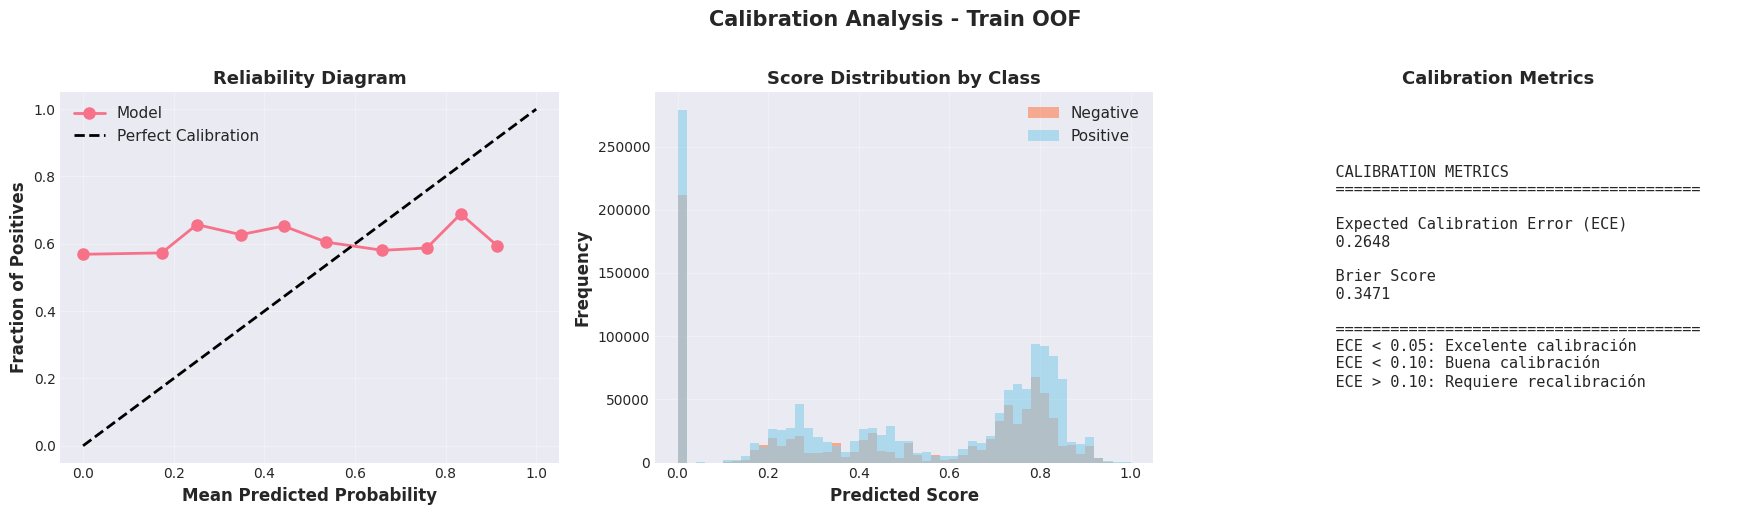


📊 Train OOF Calibration:
  ECE: 0.2648
  Brier: 0.3471


In [9]:
def plot_calibration_analysis(y_true, y_score, title='Calibration Analysis'):
    """
    Análisis completo de calibración del modelo incluyendo:
    - Reliability Diagram (curva de calibración)
    - Distribución de scores por clase
    - Métricas de calibración (ECE y Brier Score)
    
    Args:
        y_true: Array de labels verdaderas (0/1)
        y_score: Array de probabilidades predichas
        title: Título para el plot
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 1. Reliability Diagram
    prob_true, prob_pred = calibration_curve(y_true, y_score, n_bins=10)
    axes[0].plot(prob_pred, prob_true, marker='o', linewidth=2, markersize=8, label='Model')
    axes[0].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect Calibration')
    axes[0].set_xlabel('Mean Predicted Probability', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Fraction of Positives', fontsize=12, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].set_title('Reliability Diagram', fontsize=13, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # 2. Score Distribution by Class
    axes[1].hist(y_score[y_true == 0], bins=50, alpha=0.6, label='Negative', color='coral')
    axes[1].hist(y_score[y_true == 1], bins=50, alpha=0.6, label='Positive', color='skyblue')
    axes[1].set_xlabel('Predicted Score', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].set_title('Score Distribution by Class', fontsize=13, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    # 3. Calibration Metrics
    ece = np.abs(prob_true - prob_pred).mean()
    brier = brier_score_loss(y_true, y_score)
    
    axes[2].axis('off')
    metrics_text = f"""
    CALIBRATION METRICS
    {'='*40}
    
    Expected Calibration Error (ECE)
    {ece:.4f}
    
    Brier Score
    {brier:.4f}
    
    {'='*40}
    ECE < 0.05: Excelente calibración
    ECE < 0.10: Buena calibración
    ECE > 0.10: Requiere recalibración
    """
    axes[2].text(0.1, 0.5, metrics_text, fontsize=11, family='monospace',
                 verticalalignment='center')
    axes[2].set_title('Calibration Metrics', fontsize=13, fontweight='bold')
    
    plt.suptitle(title, fontsize=15, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    return {'ECE': ece, 'Brier': brier}

# EJECUTAR ANÁLISIS DE CALIBRACIÓN
print("\n" + "="*80)
print("ANÁLISIS DE CALIBRACIÓN - TRAIN OOF")
print("="*80)

cal_metrics_train = plot_calibration_analysis(
    y_train, 
    m_w30.oof_pred_,
    title='Calibration Analysis - Train OOF'
)

print(f"\n📊 Train OOF Calibration:")
print(f"  ECE: {cal_metrics_train['ECE']:.4f}")
print(f"  Brier: {cal_metrics_train['Brier']:.4f}")



THRESHOLD OPTIMIZATION - VALIDATION SET


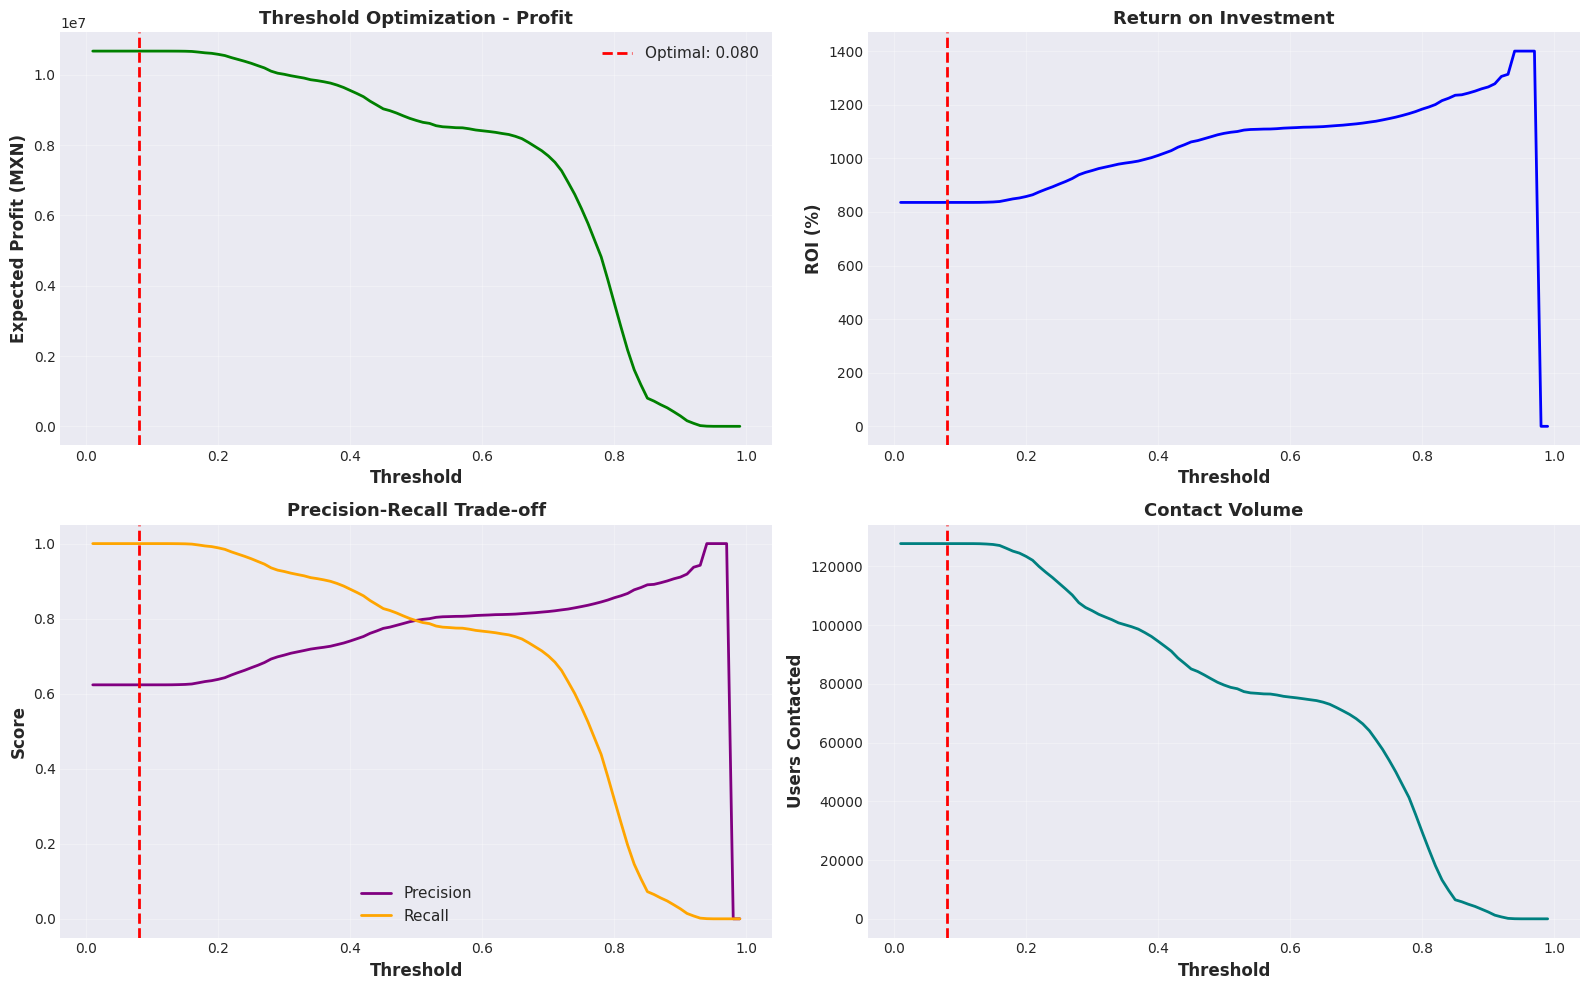


🎯 THRESHOLD ÓPTIMO: 0.0800

💰 MÉTRICAS DE NEGOCIO (Validation Set):
  Usuarios a contactar: 127,780
  True Positives: 79,684
  False Positives: 48,096
  Precision: 0.624
  Recall: 1.000

💵 IMPACTO ECONÓMICO:
  Revenue: $11,952,600 MXN
  Cost: $1,277,800 MXN
  Profit: $10,674,800 MXN
  ROI: 835.4%


In [10]:
def find_optimal_threshold(y_true, y_score, cost_per_contact=10, 
                          value_per_activation=150):
    """
    Encuentra el threshold óptimo que maximiza el profit esperado.
    
    Profit = (TP * value_per_activation) - ((TP + FP) * cost_per_contact)
    
    Args:
        y_true: Array de labels verdaderas
        y_score: Array de probabilidades predichas
        cost_per_contact: Costo de contactar a un usuario (MXN)
        value_per_activation: Valor de una activación exitosa (MXN)
    
    Returns:
        tuple: (optimal_threshold, max_profit, metrics_df)
    """
    thresholds = np.linspace(0.01, 0.99, 99)
    results = []
    
    for thresh in thresholds:
        y_pred = (y_score >= thresh).astype(int)
        
        # Confusion matrix
        tn = ((y_pred == 0) & (y_true == 0)).sum()
        fp = ((y_pred == 1) & (y_true == 0)).sum()
        fn = ((y_pred == 0) & (y_true == 1)).sum()
        tp = ((y_pred == 1) & (y_true == 1)).sum()
        
        # Métricas de negocio
        contacted = tp + fp
        revenue = tp * value_per_activation
        cost = contacted * cost_per_contact
        profit = revenue - cost
        
        # ROI y otras métricas
        roi_pct = (profit / cost * 100) if cost > 0 else 0
        precision = tp / contacted if contacted > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        results.append({
            'threshold': thresh,
            'contacted': contacted,
            'tp': tp,
            'fp': fp,
            'fn': fn,
            'precision': precision,
            'recall': recall,
            'revenue_mxn': revenue,
            'cost_mxn': cost,
            'profit_mxn': profit,
            'roi_pct': roi_pct
        })
    
    df_results = pd.DataFrame(results)
    optimal_idx = df_results['profit_mxn'].idxmax()
    optimal_thresh = df_results.loc[optimal_idx, 'threshold']
    max_profit = df_results.loc[optimal_idx, 'profit_mxn']
    
    # Visualización
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # 1. Profit vs Threshold
    ax1 = axes[0, 0]
    ax1.plot(df_results['threshold'], df_results['profit_mxn'], 
             linewidth=2, color='green')
    ax1.axvline(optimal_thresh, color='red', linestyle='--', linewidth=2,
                label=f'Optimal: {optimal_thresh:.3f}')
    ax1.set_xlabel('Threshold', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Expected Profit (MXN)', fontsize=12, fontweight='bold')
    ax1.set_title('Threshold Optimization - Profit', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # 2. ROI vs Threshold
    ax2 = axes[0, 1]
    ax2.plot(df_results['threshold'], df_results['roi_pct'], 
             linewidth=2, color='blue')
    ax2.axvline(optimal_thresh, color='red', linestyle='--', linewidth=2)
    ax2.set_xlabel('Threshold', fontsize=12, fontweight='bold')
    ax2.set_ylabel('ROI (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Return on Investment', fontsize=13, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # 3. Precision/Recall vs Threshold
    ax3 = axes[1, 0]
    ax3.plot(df_results['threshold'], df_results['precision'], 
             linewidth=2, label='Precision', color='purple')
    ax3.plot(df_results['threshold'], df_results['recall'], 
             linewidth=2, label='Recall', color='orange')
    ax3.axvline(optimal_thresh, color='red', linestyle='--', linewidth=2)
    ax3.set_xlabel('Threshold', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax3.set_title('Precision-Recall Trade-off', fontsize=13, fontweight='bold')
    ax3.legend(fontsize=11)
    ax3.grid(True, alpha=0.3)
    
    # 4. Volume vs Threshold
    ax4 = axes[1, 1]
    ax4.plot(df_results['threshold'], df_results['contacted'], 
             linewidth=2, color='teal')
    ax4.axvline(optimal_thresh, color='red', linestyle='--', linewidth=2)
    ax4.set_xlabel('Threshold', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Users Contacted', fontsize=12, fontweight='bold')
    ax4.set_title('Contact Volume', fontsize=13, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return optimal_thresh, max_profit, df_results

# EJECUTAR THRESHOLD OPTIMIZATION EN VALIDATION
print("\n" + "="*80)
print("THRESHOLD OPTIMIZATION - VALIDATION SET")
print("="*80)

# Generar predicciones en validation
fe_val = fb.transform(data_val)
X_val, y_val, meta_val = fe_val.X, fe_val.y, fe_val.meta
score_val = m_w30.predict_proba(X_val)

# Encontrar threshold óptimo
# AJUSTAR estos valores según tu negocio:
COST_PER_CONTACT = 10  # MXN - costo de SMS/push/campaña
VALUE_PER_ACTIVATION = 150  # MXN - valor estimado de una activación

optimal_thresh, max_profit, roi_results = find_optimal_threshold(
    y_val, 
    score_val,
    cost_per_contact=COST_PER_CONTACT,
    value_per_activation=VALUE_PER_ACTIVATION
)

# Métricas en threshold óptimo
optimal_row = roi_results[roi_results['threshold'] == optimal_thresh].iloc[0]

print(f"\n🎯 THRESHOLD ÓPTIMO: {optimal_thresh:.4f}")
print(f"\n💰 MÉTRICAS DE NEGOCIO (Validation Set):")
print(f"  Usuarios a contactar: {optimal_row['contacted']:,.0f}")
print(f"  True Positives: {optimal_row['tp']:,.0f}")
print(f"  False Positives: {optimal_row['fp']:,.0f}")
print(f"  Precision: {optimal_row['precision']:.3f}")
print(f"  Recall: {optimal_row['recall']:.3f}")
print(f"\n💵 IMPACTO ECONÓMICO:")
print(f"  Revenue: ${optimal_row['revenue_mxn']:,.0f} MXN")
print(f"  Cost: ${optimal_row['cost_mxn']:,.0f} MXN")
print(f"  Profit: ${optimal_row['profit_mxn']:,.0f} MXN")
print(f"  ROI: {optimal_row['roi_pct']:.1f}%")


In [11]:
def objective(trial):
    """
    Función objetivo para Optuna.
    Optimiza hiperparámetros usando 3-fold TimeSeriesSplit para rapidez.
    """

    params = {
        # Tasa de aprendizaje: crucial para el rendimiento y la velocidad de convergencia.
        # Rango corregido: de 0.005 (low) a 0.2 (high)
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),

        # Complejidad del árbol (estructura):
        # max_leaf_nodes es el principal control de complejidad para este estimador.
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 15, 127),

        # Regularización L2: penaliza la complejidad del modelo.
        'l2_regularization': trial.suggest_float('l2_regularization', 0.1, 10.0, log=True),

        # Requerimientos mínimos de muestras en hojas (para regularización).
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 100),

        # Profundidad máxima: puede limitar aún más la complejidad, aunque max_leaf_nodes suele ser suficiente.
        'max_depth': trial.suggest_int('max_depth', 3, 10),

        # Número de estimadores (árboles): se optimiza a través de early_stopping en lugar de un int fijo.
        'max_iter': 1000, # Se establece un valor alto y se usa early_stopping

        # Parámetros fijos o menos críticos (generalmente no se optimizan):
        'max_bins': 255, # Valor por defecto y máximo permitido, casi siempre óptimo.
        'loss': 'log_loss', # Función de pérdida típica para clasificación binaria/multiclase.

        # Parámetros de control de early stopping (útiles para optimizar 'max_iter'):
        'early_stopping': True,
        'validation_fraction': 0.2, # Proporción de datos para validación interna
        'n_iter_no_change': trial.suggest_int('n_iter_no_change', 10, 30), # Paciencia para early stopping

        # Semilla para reproducibilidad
        'random_state': CFG.random_state
    }
    
    # Simple 3-fold CV para rapidez
    tscv = TimeSeriesSplit(n_splits=3)
    time_order_train = pd.to_datetime(data_train[CFG.signup_date_col]).values
    
    # Ordenar datos
    order = np.argsort(time_order_train)
    X_sorted = X_train.iloc[order].reset_index(drop=True)
    y_sorted = y_train[order]
    
    scores = []
    
    for train_idx, val_idx in tscv.split(X_sorted):
        # Aplicar embargo simple
        train_dates = pd.to_datetime(time_order_train[order][train_idx])
        last_train = train_dates.max()
        embargo_cutoff = last_train + pd.Timedelta(days=CFG.embargo_days)
        
        val_dates = pd.to_datetime(time_order_train[order][val_idx])
        val_mask = val_dates >= embargo_cutoff
        val_idx_filtered = val_idx[val_mask]
        
        if len(val_idx_filtered) < 100:
            val_idx_filtered = val_idx  # Fallback si muy pocos datos
        
        # Entrenar
        model = HistGradientBoostingClassifier(**params)
        sw = compute_sample_weight(class_weight="balanced", y=y_sorted[train_idx])
        model.fit(X_sorted.iloc[train_idx], y_sorted[train_idx], sample_weight=sw)
        
        # Predecir
        pred = model.predict_proba(X_sorted.iloc[val_idx_filtered])[:, 1]
        score = average_precision_score(y_sorted[val_idx_filtered], pred)
        scores.append(score)
    
    return np.mean(scores)

# Crear estudio y optimizar
print("Iniciando optimización (50 trials)...")
print("Esto puede tomar varios minutos...\n")

study = optuna.create_study(
    direction='maximize',
    pruner=MedianPruner(),
    study_name='spin_activation_hpo'
)

study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\n✅ OPTIMIZACIÓN COMPLETADA\n")
print(f"🏆 Mejor Average Precision: {study.best_value:.4f}")
print(f"\n🎯 Mejores Hiperparámetros:")
for param, value in study.best_params.items():
    print(f"  {param}: {value}")

# Visualizar resultados
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# 1. Historia de optimización
ax1 = axes[0]
trials_values = [trial.value for trial in study.trials if trial.value is not None]
ax1.plot(trials_values, marker='o', linewidth=1.5)
ax1.axhline(study.best_value, color='red', linestyle='--', 
            label=f'Best: {study.best_value:.4f}')
ax1.set_xlabel('Trial', fontsize=12, fontweight='bold')
ax1.set_ylabel('Average Precision', fontsize=12, fontweight='bold')
ax1.set_title('Optimization History', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# 2. Importancia de parámetros
ax2 = axes[1]
param_importance = optuna.importance.get_param_importances(study)
params = list(param_importance.keys())
importances = list(param_importance.values())
ax2.barh(params, importances)
ax2.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax2.set_title('Parameter Importance', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Guardar mejores parámetros para usar en modelo final
BEST_PARAMS = study.best_params
print("\n📝 Usar estos parámetros en _make_model() del modelo final")

[I 2025-11-24 21:31:31,794] A new study created in memory with name: spin_activation_hpo


Iniciando optimización (50 trials)...
Esto puede tomar varios minutos...



  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-11-24 21:36:34,980] Trial 0 finished with value: 0.8130673095270636 and parameters: {'learning_rate': 0.006602631364216021, 'max_leaf_nodes': 40, 'l2_regularization': 0.5136402976534428, 'min_samples_leaf': 7, 'max_depth': 9, 'n_iter_no_change': 16}. Best is trial 0 with value: 0.8130673095270636.
[I 2025-11-24 21:39:47,530] Trial 1 finished with value: 0.8130109397981521 and parameters: {'learning_rate': 0.024613949046054507, 'max_leaf_nodes': 121, 'l2_regularization': 4.27132529625838, 'min_samples_leaf': 72, 'max_depth': 9, 'n_iter_no_change': 15}. Best is trial 0 with value: 0.8130673095270636.
[W 2025-11-24 21:41:08,172] Trial 2 failed with parameters: {'learning_rate': 0.028303078580598134, 'max_leaf_nodes': 125, 'l2_regularization': 0.6815363798379874, 'min_samples_leaf': 43, 'max_depth': 6, 'n_iter_no_change': 27} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/optuna/study/_optimize

KeyboardInterrupt: 

In [12]:
def lift_at_k(y_true, y_score, frac: float) -> float:
    n = len(y_true); k = max(1, int(n*frac))
    idx = np.argpartition(-y_score, k-1)[:k]
    top_pos = y_true[idx].sum()
    base_rate = y_true.mean()
    expected_pos = k*base_rate
    return float(top_pos/expected_pos) if expected_pos>0 else np.nan

class Activation30Model:
    def __init__(self, cfg: Config):
        self.cfg = cfg
        self.model_folds_: t.List[HistGradientBoostingClassifier] = []
        self.iso_folds_: t.List[IsotonicRegression] = []
        self.metrics_ = {}
        self.oof_pred_ = None
        self.feature_names_: t.List[str] = []

    def _make_model(self):
        return HistGradientBoostingClassifier(
            learning_rate=0.05, max_leaf_nodes=31, min_samples_leaf=50,
            l2_regularization=1.0, max_bins=255, random_state=self.cfg.random_state
        )
    def _apply_embargo(self, train_idx: np.ndarray, val_idx: np.ndarray, 
                       time_order: np.ndarray) -> t.Tuple[np.ndarray, np.ndarray]:
        """Purga registros del train/val que violen el embargo temporal"""
        if self.cfg.embargo_days == 0:
            return train_idx, val_idx

        # Convertir a pandas Timestamp para operaciones seguras
        train_dates = pd.to_datetime(time_order[train_idx])
        val_dates = pd.to_datetime(time_order[val_idx])

        # Última fecha de train
        last_train_date = train_dates.max()

        # Calcular embargo cutoff
        embargo_cutoff = last_train_date + pd.Timedelta(days=self.cfg.embargo_days)

        # Filtrar validación
        val_valid_mask = val_dates >= embargo_cutoff
        val_filtered = val_idx[val_valid_mask]

        # VALIDACIÓN CRÍTICA: Asegurar mínimo de muestras
        min_samples = 100  # mínimo razonable para HistGradientBoosting
        if len(val_filtered) < min_samples:
            print(f" WARNING: Embargo dejó {len(val_filtered)} muestras (< {min_samples}). "
                  f"Usando fold completo sin embargo.")
            return train_idx, val_idx

        removed = len(val_idx) - len(val_filtered)
        print(f"✓ Embargo aplicado: {removed} muestras removidas de validación "
              f"({removed/len(val_idx)*100:.1f}%)")

        return train_idx, val_filtered

def fit_cv(self, X: pd.DataFrame, y: np.ndarray, time_order: np.ndarray):
    """
    Entrena el modelo usando TimeSeriesSplit CV con embargo temporal
    y visualización de estabilidad por fold.
    """
    # Ordenar temporal
    order = np.argsort(time_order)
    X = X.iloc[order].reset_index(drop=True)
    y = y[order]
    time_order_sorted = pd.to_datetime(time_order[order])

    tss = TimeSeriesSplit(n_splits=self.cfg.n_splits)
    oof = np.zeros(len(X), dtype=float)
    self.model_folds_.clear()
    self.iso_folds_.clear()
    self.feature_names_ = X.columns.tolist()
    
    fold_metrics = []  # Track metrics per fold

    for f, (tr, va) in enumerate(tss.split(X)):
        # Embargo con fechas ya ordenadas
        tr, va = self._apply_embargo(tr, va, time_order_sorted)

        Xtr, Xva = X.iloc[tr], X.iloc[va]
        ytr, yva = y[tr], y[va]

        sw = compute_sample_weight(class_weight="balanced", y=ytr).astype("float32")

        m = self._make_model()
        m.fit(Xtr, ytr, sample_weight=sw)

        p_raw = m.predict_proba(Xva)[:, 1]
        iso = IsotonicRegression(out_of_bounds="clip").fit(p_raw, yva)
        p_cal = iso.transform(p_raw)
        oof[va] = p_cal

        self.model_folds_.append(m)
        self.iso_folds_.append(iso)
        
        # Calcular métricas del fold
        fold_ap = average_precision_score(yva, p_cal)
        fold_auc = roc_auc_score(yva, p_cal)
        fold_brier = brier_score_loss(yva, p_cal)
        
        fold_metrics.append({
            'fold': f + 1,
            'AP': fold_ap,
            'AUC': fold_auc,
            'Brier': fold_brier
        })
        
        print(f"[Fold {f+1}] AP={fold_ap:.4f} | AUC={fold_auc:.4f} | Brier={fold_brier:.4f}")

    self.oof_pred_ = oof
    self.metrics_ = {
        "OOF_AP": average_precision_score(y, oof),
        "OOF_AUC": roc_auc_score(y, oof),
        "OOF_Brier": brier_score_loss(y, oof),
        **{f"OOF_Lift@{int(fr*100)}%": lift_at_k(y, oof, fr) for fr in self.cfg.lift_fracs}
    }
    
    # NUEVO: Visualizar estabilidad por fold
    df_folds = pd.DataFrame(fold_metrics)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Plot 1: Métricas por fold
    ax1 = axes[0]
    ax1.plot(df_folds['fold'], df_folds['AP'], marker='o', linewidth=2, 
             markersize=8, label='AP', color='blue')
    ax1.plot(df_folds['fold'], df_folds['AUC'], marker='s', linewidth=2,
             markersize=8, label='AUC', color='green')
    ax1.axhline(df_folds['AP'].mean(), color='blue', linestyle='--', 
                alpha=0.5, label=f'Mean AP: {df_folds["AP"].mean():.4f}')
    ax1.axhline(df_folds['AUC'].mean(), color='green', linestyle='--',
                alpha=0.5, label=f'Mean AUC: {df_folds["AUC"].mean():.4f}')
    ax1.set_xlabel('Fold', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax1.set_title('Temporal CV Stability - Performance', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 1])
    
    # Plot 2: Brier Score por fold
    ax2 = axes[1]
    ax2.plot(df_folds['fold'], df_folds['Brier'], marker='^', linewidth=2,
             markersize=8, label='Brier Score', color='coral')
    ax2.axhline(df_folds['Brier'].mean(), color='coral', linestyle='--',
                alpha=0.5, label=f'Mean: {df_folds["Brier"].mean():.4f}')
    ax2.set_xlabel('Fold', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Brier Score', fontsize=12, fontweight='bold')
    ax2.set_title('Temporal CV Stability - Calibration', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas de estabilidad
    print(f"\n📊 ESTABILIDAD TEMPORAL:")
    print(f"  AP  → Mean: {df_folds['AP'].mean():.4f} | Std: {df_folds['AP'].std():.4f}")
    print(f"  AUC → Mean: {df_folds['AUC'].mean():.4f} | Std: {df_folds['AUC'].std():.4f}")
    
    return self


    def predict_proba(self, X: pd.DataFrame) -> np.ndarray:
        preds = np.zeros(len(X), dtype=float)
        for m, iso in zip(self.model_folds_, self.iso_folds_):
            preds += iso.transform(m.predict_proba(X)[:,1])
        return preds / max(1, len(self.model_folds_))


In [13]:
def _make_model(self):
    """
    Crea un HistGradientBoostingClassifier con los mejores hiperparámetros
    encontrados por Optuna (o valores por defecto si no se ejecutó HPO).
    """
    # Si existen BEST_PARAMS de Optuna, usarlos
    if 'BEST_PARAMS' in globals():
        return HistGradientBoostingClassifier(
            learning_rate=BEST_PARAMS['learning_rate'],
            max_leaf_nodes=BEST_PARAMS['max_leaf_nodes'],
            min_samples_leaf=BEST_PARAMS['min_samples_leaf'],
            l2_regularization=BEST_PARAMS['l2_regularization'],
            max_bins=BEST_PARAMS.get('max_bins', 255),
            random_state=self.cfg.random_state
        )
    else:
        # Valores por defecto
        return HistGradientBoostingClassifier(
            learning_rate=0.05, 
            max_leaf_nodes=31, 
            min_samples_leaf=50,
            l2_regularization=1.0, 
            max_bins=255, 
            random_state=self.cfg.random_state
        )

=== MÉTRICAS W30 (ACTIVACIÓN) ===

  Test_AP: 0.8321
  Test_AUC: 0.7741
  Test_Brier: 0.1776
  Test_Lift@1%: 1.4374
  Test_Lift@2%: 1.4209
  Test_Lift@5%: 1.3867
  Test_Lift@10%: 1.3700

=== COMPARACIÓN TRAIN / VALIDATION / TEST ===

  metric  train_oof  validation     test
      AP   0.769691    0.824060 0.832089
     AUC   0.660202    0.774025 0.774058
   Brier   0.280005    0.180159 0.177620
 Lift@1%   1.495987    1.474300 1.437362
 Lift@5%   1.443852    1.427695 1.386678
Lift@10%   1.405144    1.407489 1.370004

=== CALIBRACIÓN EN TEST SET ===


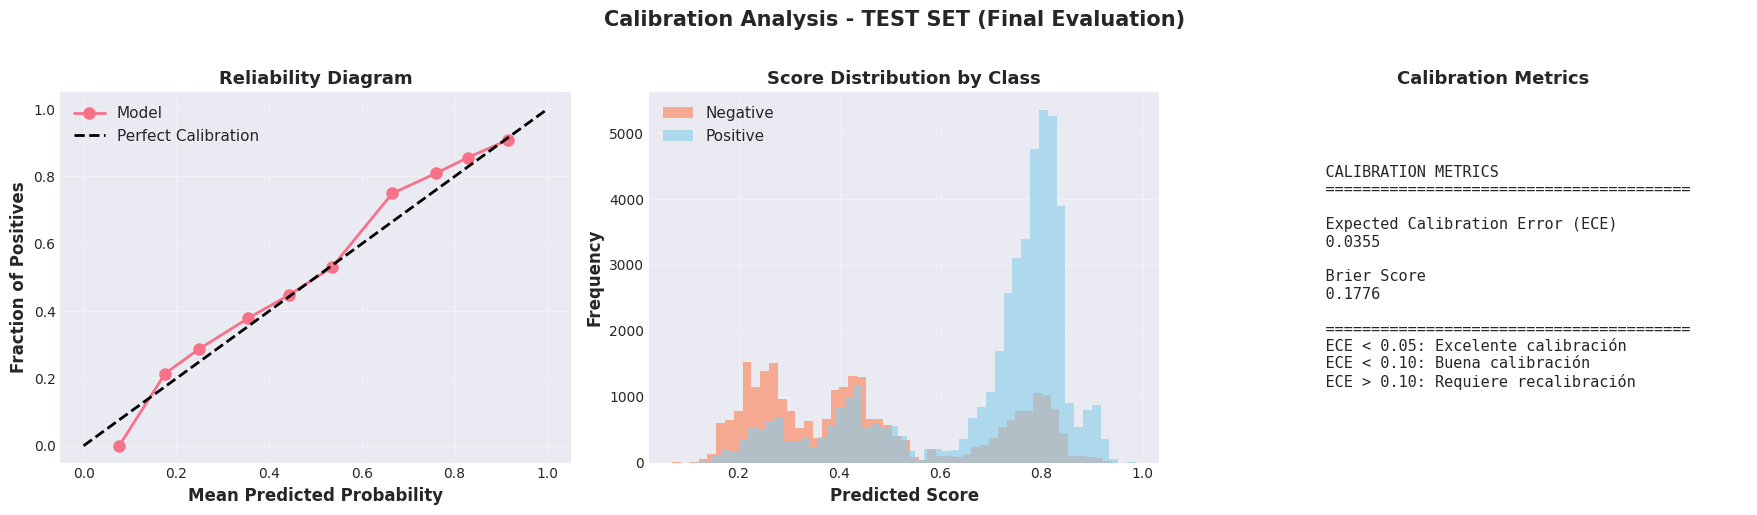


=== PERFORMANCE CON THRESHOLD ÓPTIMO (0.0800) ===

Confusion Matrix (Test Set):
          Pred 0  Pred 1
Actual 0       2   27319
Actual 1       0   48514

Classification Report (Test Set):
              precision    recall  f1-score   support

No Activated       1.00      0.00      0.00     27321
   Activated       0.64      1.00      0.78     48514

    accuracy                           0.64     75835
   macro avg       0.82      0.50      0.39     75835
weighted avg       0.77      0.64      0.50     75835


=== PROYECCIÓN DE NEGOCIO (TEST SET) ===
  Usuarios a contactar: 75,833
  Activaciones esperadas: 48,514
  Precision: 0.640

💰 IMPACTO ECONÓMICO PROYECTADO:
  Revenue: $7,277,100 MXN
  Cost: $758,330 MXN
  Profit: $6,518,770 MXN
  ROI: 859.6%

=== ANÁLISIS DE CONSISTENCIA ===
  AP drop Train→Val: -7.1%
  AP drop Train→Test: -8.1%
  ✅ Excelente generalización

=== EXPORTAR RESULTADOS FINALES ===
  comparison_df.to_csv('final_train_val_test_comparison.csv', index=False)
  # Usar

In [14]:
# Feature engineering en test
fe_test = fb.transform(data_test)
X_test, y_test, meta_test = fe_test.X, fe_test.y, fe_test.meta

# Predicciones W30
score_test_w30 = m_w30.predict_proba(X_test)

# Métricas de activación
test_metrics_w30 = {
    "Test_AP": average_precision_score(y_test, score_test_w30),
    "Test_AUC": roc_auc_score(y_test, score_test_w30),
    "Test_Brier": brier_score_loss(y_test, score_test_w30),
    **{f"Test_Lift@{int(fr*100)}%": lift_at_k(y_test, score_test_w30, fr) 
       for fr in CFG.lift_fracs}
}

print("=== MÉTRICAS W30 (ACTIVACIÓN) ===\n")
for k, v in test_metrics_w30.items():
    print(f"  {k}: {v:.4f}")

# Comparación Train/Val/Test
comparison_df = pd.DataFrame({
    'metric': ['AP', 'AUC', 'Brier', 'Lift@1%', 'Lift@5%', 'Lift@10%'],
    'train_oof': [
        m_w30.metrics_['OOF_AP'],
        m_w30.metrics_['OOF_AUC'],
        m_w30.metrics_['OOF_Brier'],
        m_w30.metrics_['OOF_Lift@1%'],
        m_w30.metrics_['OOF_Lift@5%'],
        m_w30.metrics_['OOF_Lift@10%']
    ],
    'validation': [
        average_precision_score(y_val, score_val),
        roc_auc_score(y_val, score_val),
        brier_score_loss(y_val, score_val),
        lift_at_k(y_val, score_val, 0.01),
        lift_at_k(y_val, score_val, 0.05),
        lift_at_k(y_val, score_val, 0.10)
    ],
    'test': [
        test_metrics_w30['Test_AP'],
        test_metrics_w30['Test_AUC'],
        test_metrics_w30['Test_Brier'],
        test_metrics_w30['Test_Lift@1%'],
        test_metrics_w30['Test_Lift@5%'],
        test_metrics_w30['Test_Lift@10%']
    ]
})

print("\n=== COMPARACIÓN TRAIN / VALIDATION / TEST ===\n")
print(comparison_df.to_string(index=False))

# Análisis de calibración en test
print("\n=== CALIBRACIÓN EN TEST SET ===")
cal_metrics_test = plot_calibration_analysis(
    y_test, 
    score_test_w30,
    title='Calibration Analysis - TEST SET (Final Evaluation)'
)

# Aplicar threshold óptimo en test
y_pred_test_optimal = (score_test_w30 >= optimal_thresh).astype(int)

print(f"\n=== PERFORMANCE CON THRESHOLD ÓPTIMO ({optimal_thresh:.4f}) ===")
print(f"\nConfusion Matrix (Test Set):")
cm_test = confusion_matrix(y_test, y_pred_test_optimal)
cm_df = pd.DataFrame(cm_test, 
                      index=['Actual 0', 'Actual 1'],
                      columns=['Pred 0', 'Pred 1'])
print(cm_df)

print(f"\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test_optimal, 
                           target_names=['No Activated', 'Activated']))

# Análisis de ROI en test
tp_test = ((y_pred_test_optimal == 1) & (y_test == 1)).sum()
fp_test = ((y_pred_test_optimal == 1) & (y_test == 0)).sum()
contacted_test = tp_test + fp_test
revenue_test = tp_test * VALUE_PER_ACTIVATION
cost_test = contacted_test * COST_PER_CONTACT
profit_test = revenue_test - cost_test
roi_test = (profit_test / cost_test * 100) if cost_test > 0 else 0

print(f"\n=== PROYECCIÓN DE NEGOCIO (TEST SET) ===")
print(f"  Usuarios a contactar: {contacted_test:,}")
print(f"  Activaciones esperadas: {tp_test:,}")
print(f"  Precision: {tp_test/contacted_test:.3f}")
print(f"\n💰 IMPACTO ECONÓMICO PROYECTADO:")
print(f"  Revenue: ${revenue_test:,.0f} MXN")
print(f"  Cost: ${cost_test:,.0f} MXN")
print(f"  Profit: ${profit_test:,.0f} MXN")
print(f"  ROI: {roi_test:.1f}%")

# Verificar consistencia entre splits
print("\n=== ANÁLISIS DE CONSISTENCIA ===")
ap_drop_val = (comparison_df.loc[0, 'train_oof'] - comparison_df.loc[0, 'validation']) / comparison_df.loc[0, 'train_oof'] * 100
ap_drop_test = (comparison_df.loc[0, 'train_oof'] - comparison_df.loc[0, 'test']) / comparison_df.loc[0, 'train_oof'] * 100

print(f"  AP drop Train→Val: {ap_drop_val:.1f}%")
print(f"  AP drop Train→Test: {ap_drop_test:.1f}%")

if abs(ap_drop_test) < 10:
    print("  ✅ Excelente generalización")
elif abs(ap_drop_test) < 20:
    print("  ✓ Buena generalización")
else:
    print("  ⚠️  Revisar: posible overfitting o data drift")

# Guardar resultados finales
print("\n=== EXPORTAR RESULTADOS FINALES ===")
print("  comparison_df.to_csv('final_train_val_test_comparison.csv', index=False)")
print("  # Usar score_test_w30 para scoring en producción")

print("\n" + "="*80)
print("✅ EVALUACIÓN FINAL COMPLETADA")
print("="*80)

In [15]:
from pathlib import Path
from dataclasses import asdict
import json
import joblib
import sys

ARTIFACTS_DIR = Path("artifacts")


def save_training_artifacts(artifacts_dir: Path = ARTIFACTS_DIR) -> None:
    artifacts_dir = Path(artifacts_dir)
    artifacts_dir.mkdir(parents=True, exist_ok=True)

    cfg_dict = asdict(CFG)

    train_info = {
        "project_id": CFG.project_id,
        "table_fqn": CFG.table_fqn,
        "label_col": CFG.label_col,
        "signup_ts_col": CFG.signup_ts_col,
        "signup_date_col": CFG.signup_date_col,
        "n_total": int(len(data_raw)),
        "n_train": int(len(data_train)),
        "n_val": int(len(data_val)),
        "n_test": int(len(data_test)),
        "pos_rate_total": float(data_raw[CFG.label_col].mean()),
        "pos_rate_train": float(data_train[CFG.label_col].mean()),
        "pos_rate_val": float(data_val[CFG.label_col].mean()),
        "pos_rate_test": float(data_test[CFG.label_col].mean()),
        "train_date_min": str(data_train[CFG.signup_date_col].min()),
        "train_date_max": str(data_train[CFG.signup_date_col].max()),
        "val_date_min": str(data_val[CFG.signup_date_col].min()),
        "val_date_max": str(data_val[CFG.signup_date_col].max()),
        "test_date_min": str(data_test[CFG.signup_date_col].min()),
        "test_date_max": str(data_test[CFG.signup_date_col].max()),
    }

    with open(artifacts_dir / "config.json", "w") as f:
        json.dump(cfg_dict, f, indent=2, default=str)

    with open(artifacts_dir / "train_val_test_info.json", "w") as f:
        json.dump(train_info, f, indent=2, default=str)


        # 2) FEATURE ENGINEERING / TRANSFORMACIÓN

    # FeatureBuilder 
    joblib.dump(fb, artifacts_dir / "feature_builder.pkl")

    fe_meta = {
        "numeric_cols": getattr(fb, "numeric_cols_", []),
        "state_ohe_cols": getattr(fb, "ohe_states_", []),
        "scaler": type(getattr(fb, "scaler_", None)).__name__
        if getattr(fb, "scaler_", None) is not None
        else None,
    }

    with open(artifacts_dir / "feature_builder_meta.json", "w") as f:
        json.dump(fe_meta, f, indent=2, default=str)

    # MODEL 30D (ACTIVACIÓN BINARIA W30)
    # Model complete (folds + calibradores + métricas OOF)
    this_module = sys.modules[__name__]
    this_module.Activation30Model = m_w30.__class__
    
    joblib.dump(m_w30, artifacts_dir / "model_activation_30d.pkl")

    # Feature names usados por el modelo
    feature_names = list(getattr(m_w30, "feature_names_", []))
    if not feature_names:
        # fallback limpio
        feature_names = list(X_train.columns)

    activation_summary = {
        "model_type": "HistGradientBoostingClassifier + Isotonic (k-fold)",
        "n_folds": len(m_w30.model_folds_),
        "base_params": m_w30.model_folds_[0].get_params()
        if len(m_w30.model_folds_) > 0
        else None,
        "metrics_oof": m_w30.metrics_,          # AP, AUC, Brier, Lift@k (train OOF)
        "metrics_holdout": holdout_metrics,     # AP, AUC, Brier, Lift@k (holdout)
        "feature_names": feature_names,
        "label_col": CFG.label_col,
        "train_size": int(len(X_train)),
        "holdout_size": int(len(X_holdout)),
        "pos_rate_train": float(y_train.mean()),
        "pos_rate_holdout": float(y_holdout.mean()),
    }

    with open(artifacts_dir / "model_activation_30d_summary.json", "w") as f:
        json.dump(activation_summary, f, indent=2, default=str)

    # MODEL  TyPE of TRANSACTION (Cash_In/SPEI/P2P)
    joblib.dump(m_tx, artifacts_dir / "model_tx_type.pkl")

    tx_params = m_tx.model_.get_params() if getattr(m_tx, "model_", None) is not None else None

    tx_summary = {
        "model_type": "HistGradientBoostingClassifier (multiclase)",
        "classes": {int(k): v for k, v in TX_TYPE_NAMES.items()},
        "base_params": tx_params,
    }

    with open(artifacts_dir / "model_tx_type_summary.json", "w") as f:
        json.dump(tx_summary, f, indent=2, default=str)

    # PREDICCIONES COMPLETAS A CSV
    #    (score 30d + recomendación de canal)
    preds_path = artifacts_dir / "preds_w30_tx.csv"
    preds_w30_tx.to_csv(preds_path, index=False)
     # ----------------------------------------------
    # 6) README SENCILLO (opcional pero útil)
    # ----------------------------------------------
    readme = f"""# Model 1.2.0 – Activación 30d + Tipo de Transacción

    Este folder contiene los artefactos de entrenamiento del modelo de Activación 30d
    y el modelo multiclase de tipo de primera transacción.

    Archivos clave:
    - config.json                         → Configuración de entrenamiento (tabla origen, columnas, seeds, etc.)
    - train_val_test_info.json            → Tamaños, fechas y tasas de activación por split.
    - feature_builder.pkl                 → Objeto FeatureBuilder (feature engineering + scaler).
    - feature_builder_meta.json           → Listas de columnas numéricas y OHE, tipo de scaler.
    - model_activation_30d.pkl            → Modelo W30 entrenado (folds + calibradores).
    - model_activation_30d_summary.json   → Métricas OOF/Holdout + features usadas.
    - model_tx_type.pkl                   → Modelo multiclase Cash_In / SPEI / P2P.
    - model_tx_type_summary.json          → Hiperparámetros y mapping de clases.
    - preds_w30_tx.csv                    → Predicciones por usuario (scores + recomendación de canal).

    ARTIFACT_VERSION = "1.1.4"
    ARTIFACTS_DIR = "{artifacts_dir}"
    """
    with open(artifacts_dir / "README.md", "w") as f:
        f.write(readme)

        print(f"✅ Artefactos guardados en: {artifacts_dir.resolve()}")
        print("   - config.json")
        print("   - train_val_test_info.json")
        print("   - feature_builder.pkl + feature_builder_meta.json")
        print("   - model_activation_30d.pkl + model_activation_30d_summary.json")
        print("   - model_tx_type.pkl + model_tx_type_summary.json")
        print(f"   - preds_w30_tx.csv")
        print("   - README.md")
# Llama esto al final del notebook cuando ya entrenaste todo:
save_training_artifacts()

✅ Artefactos guardados en: /home/jupyter/CashIN_model/HistGB/Base/Horizont_30_Day/Model_1.2.0/artifacts
   - config.json
   - train_val_test_info.json
   - feature_builder.pkl + feature_builder_meta.json
   - model_activation_30d.pkl + model_activation_30d_summary.json
   - model_tx_type.pkl + model_tx_type_summary.json
   - preds_w30_tx.csv
   - README.md


# Simple execution

In [33]:
from __future__ import annotations

from pathlib import Path
import json
import re
from typing import Optional, Sequence, Tuple

import joblib
import pandas as pd
from google.cloud import bigquery
from sklearn.utils import Bunch  # <- para detectar el output del FeatureBuilder

In [28]:
# Ruta base de artefactos (ajusta si la mueves de lugar)
ARTIFACTS_DIR = Path("artifacts")

# Proyecto y tabla de BigQuery de donde leeremos el batch
BQ_PROJECT_ID = "spin-aip-singularity-comp-sb"
BQ_TABLE_FQN = (
    "spin-aip-singularity-comp-sb.model_activation."
    "dataste_model_activation_timewindow_30D_V-1-5-0"
)

DEFAULT_ID_COLS = ["user_id"]

In [29]:
def read_data(
    project_id: str = BQ_PROJECT_ID,
    table_fqn: str = BQ_TABLE_FQN,
    where_clause: Optional[str] = None,
    limit: Optional[int] = None,
) -> pd.DataFrame:
    """
    Lee datos desde BigQuery en un DataFrame de pandas.

    Parameters
    ----------
    project_id : str
        ID del proyecto de GCP.
    table_fqn : str
        Nombre completo de la tabla en formato `project.dataset.table`
        o ``project.dataset.view``.
    where_clause : str, opcional
        Condición WHERE sin la palabra 'WHERE'.
        Ejemplo: "signup_date BETWEEN '2024-01-01' AND '2024-01-31'".
    limit : int, opcional
        Límite de filas a leer. Si es None, no se agrega LIMIT.

    Returns
    -------
    pd.DataFrame
        Datos crudos leídos de BigQuery.
    """
    client = bigquery.Client(project=project_id)

    query = f"SELECT * FROM `{table_fqn}`"
    if where_clause:
        query += f" WHERE {where_clause}"
    if limit is not None:
        query += f" LIMIT {int(limit)}"

    print("[INFO] Ejecutando query de BigQuery:")
    print(query)

    df = client.query(query).to_dataframe()
    print(f"[INFO] Filas leídas desde BQ: {len(df):,}")
    return df

In [30]:
def load_artifacts(
    artifacts_dir: Path,
) -> Tuple[object, object, object, Optional[dict], Optional[dict]]:
    """
    Carga los artefactos necesarios para inferencia.

    Parameters
    ----------
    artifacts_dir : Path
        Carpeta donde viven los artefactos del modelo.

    Returns
    -------
    feature_builder : object
        Objeto FeatureBuilder usado para transformar los datos.
    model_activation_30d : object
        Modelo binario para probabilidad de activación a 30 días.
    model_tx_type : object
        Modelo (idealmente multiclase) para tipo de primera transacción.
    config : dict or None
        Contenido de config.json si existe.
    train_val_test_info : dict or None
        Contenido de train_val_test_info.json si existe.
    """
    artifacts_dir = artifacts_dir.resolve()
    print(f"[INFO] Cargando artefactos desde: {artifacts_dir}")

    # --- feature builder ---
    fb_path = artifacts_dir / "feature_builder.pkl"
    feature_builder = joblib.load(fb_path)
    print(f"[INFO] feature_builder cargado desde: {fb_path.name}")

    # --- modelos ---
    m_act_path = artifacts_dir / "model_activation_30d.pkl"
    model_activation_30d = joblib.load(m_act_path)
    print(f"[INFO] model_activation_30d cargado desde: {m_act_path.name}")

    m_tx_path = artifacts_dir / "model_tx_type.pkl"
    model_tx_type = joblib.load(m_tx_path)
    print(f"[INFO] model_tx_type cargado desde: {m_tx_path.name}")

    # --- config opcional ---
    config_path = artifacts_dir / "config.json"
    config = None
    if config_path.exists():
        with open(config_path, "r", encoding="utf-8") as f:
            config = json.load(f)
        print("[INFO] config.json cargado.")

    # --- info de splits opcional ---
    tvt_path = artifacts_dir / "train_val_test_info.json"
    train_val_test_info = None
    if tvt_path.exists():
        with open(tvt_path, "r", encoding="utf-8") as f:
            train_val_test_info = json.load(f)
        print("[INFO] train_val_test_info.json cargado.")

    return feature_builder, model_activation_30d, model_tx_type, config, train_val_test_info



In [38]:
def _sanitize_tx_class_name(cls: object) -> str:
    """
    Convierte el nombre de la clase de transacción a un nombre de columna seguro.
    Ejemplo: "Cash-In" -> "Cash_In" => columna "p_tx_Cash_In".
    """
    cls_str = str(cls)
    cls_str = re.sub(r"\W+", "_", cls_str)
    return cls_str

def _get_binary_prob(
    model: object,
    X,
) -> np.ndarray:
    """
    Devuelve probabilidad de la clase positiva para un modelo binario, siendo robustos
    a:
    - predict_proba que ya regresa un vector 1D
    - matrices 2D con clases_ donde la positiva es 1
    - fallback a última columna
    """
    proba = model.predict_proba(X)

    # Si viene como pandas, me quedo con .values
    proba = getattr(proba, "values", proba)

    if np.ndim(proba) == 1:
        # Tu Activation30Model ya hace el promedio por folds y devuelve 1D
        return proba

    if proba.shape[1] == 1:
        # Raro pero posible (única columna)
        return proba[:, 0]

    classes = getattr(model, "classes_", None)
    if classes is not None and len(classes) == proba.shape[1] and 1 in classes:
        pos_idx = list(classes).index(1)
        return proba[:, pos_idx]

    # Fallback: nos quedamos con la última columna
    return proba[:, -1]


def score_batch(
    df_raw: pd.DataFrame,
    feature_builder: object,
    model_activation_30d: object,
    model_tx_type: object,
    id_cols: Optional[Sequence[str]] = None,
) -> pd.DataFrame:
    """
    Transforma datos crudos, genera scores de activación y de tipo de transacción.
    """
    if df_raw.empty:
        print("[WARN] df_raw está vacío. No se generarán scores.")
        return pd.DataFrame()

    # IDs desde df_raw
    if id_cols:
        missing = [c for c in id_cols if c not in df_raw.columns]
        if missing:
            raise KeyError(f"Columnas ID no encontradas en df_raw: {missing}")
        df_out = df_raw[list(id_cols)].copy()
    else:
        df_out = pd.DataFrame(index=df_raw.index)

    # Transformación
    print("[INFO] Transformando features con feature_builder...")
    fb_out = feature_builder.transform(df_raw)

    if isinstance(fb_out, Bunch) or (hasattr(fb_out, "X") and hasattr(fb_out, "meta")):
        X = fb_out.X
        meta = getattr(fb_out, "meta", None)
        print(f"[INFO] FeatureBuilder devolvió Bunch: X.shape={getattr(X, 'shape', None)}")
        if not id_cols and meta is not None and "user_id" in meta.columns:
            df_out = meta[["user_id"]].copy()
    else:
        X = fb_out
        meta = None
        print(f"[INFO] FeatureBuilder devolvió matriz directa: X.shape={getattr(X, 'shape', None)}")

    # Modelo activación 30d
    print("[INFO] Scoring modelo de activación 30d...")
    if hasattr(model_activation_30d, "predict_proba"):
        p_act = _get_binary_prob(model_activation_30d, X)
        df_out["p_activation_30d"] = p_act
    else:
        y_hat = model_activation_30d.predict(X)
        df_out["p_activation_30d"] = y_hat

    # Modelo tipo de transacción
    print("[INFO] Scoring modelo de tipo de transacción...")
    if hasattr(model_tx_type, "predict_proba"):
        proba_tx = model_tx_type.predict_proba(X)
        proba_tx = getattr(proba_tx, "values", proba_tx)

        if np.ndim(proba_tx) == 1:
            # Caso raro: solo 1D, lo tratamos como predicción de una sola clase
            df_out["tx_type_pred"] = proba_tx
        else:
            classes = getattr(model_tx_type, "classes_", range(proba_tx.shape[1]))
            for idx, cls in enumerate(classes):
                cls_name = _sanitize_tx_class_name(cls)
                col_name = f"p_tx_{cls_name}"
                df_out[col_name] = proba_tx[:, idx]
    else:
        tx_pred = model_tx_type.predict(X)
        df_out["tx_type_pred"] = tx_pred

    return df_out

In [39]:

if __name__ == "__main__":
    # --- carga de artefactos ---
    (
        feature_builder,
        model_activation_30d,
        model_tx_type,
        config,
        train_val_test_info,
    ) = load_artifacts(ARTIFACTS_DIR)

    # --- lectura de datos ---
    # Si quieres filtrar por fechas, pasa where_clause, por ejemplo:
    # where = "signup_date BETWEEN '2024-01-01' AND '2024-01-31'"
    where = None
    df_raw = read_data(
        project_id=BQ_PROJECT_ID,
        table_fqn=BQ_TABLE_FQN,
        where_clause=where,
        limit=None,  # puedes pasar un entero para pruebas
    )

    # --- scoring del batch ---
    df_scores = score_batch(
        df_raw=df_raw,
        feature_builder=feature_builder,
        model_activation_30d=model_activation_30d,
        model_tx_type=model_tx_type,
        id_cols=DEFAULT_ID_COLS,  # ajusta si usas otras IDs
    )

    # --- guardado de resultados ---
    preds_path = ARTIFACTS_DIR / "preds_w30_tx_batch.csv"
    df_scores.to_csv(preds_path, index=False)
    print(f"[OK] Predicciones guardadas en: {preds_path}")

[INFO] Cargando artefactos desde: /home/jupyter/CashIN_model/HistGB/Base/Horizont_30_Day/Model_1.2.0/artifacts
[INFO] feature_builder cargado desde: feature_builder.pkl
[INFO] model_activation_30d cargado desde: model_activation_30d.pkl
[INFO] model_tx_type cargado desde: model_tx_type.pkl
[INFO] config.json cargado.
[INFO] train_val_test_info.json cargado.
[INFO] Ejecutando query de BigQuery:
SELECT * FROM `spin-aip-singularity-comp-sb.model_activation.dataste_model_activation_timewindow_30D_V-1-5-0`
[INFO] Filas leídas desde BQ: 2,384,265
[INFO] Transformando features con feature_builder...
[INFO] FeatureBuilder devolvió Bunch: X.shape=(2384265, 55)
[INFO] Scoring modelo de activación 30d...
[INFO] Scoring modelo de tipo de transacción...
[OK] Predicciones guardadas en: artifacts/preds_w30_tx_batch.csv
